In [1]:
import kagglehub

# Kaggle'dan projede kullanılacak olan datasetin indirilmesi ve dosya yolunun kaydedilmesi
path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")

print("Path to dataset files:", path)

100%|██████████| 5.20G/5.20G [02:38<00:00, 35.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2


In [2]:
    import os
    import shutil
    import pandas as pd
    from sklearn.preprocessing import LabelEncoder
    from sklearn.model_selection import train_test_split
    from sklearn.utils import resample
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
    import numpy as np
    from tensorflow.keras.callbacks import EarlyStopping
    from tensorflow.keras.optimizers import Adam
    import tensorflow as tf

    image_path1 = '/root/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2/HAM10000_images_part_1'
    image_path2 = '/root/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2/HAM10000_images_part_2'

    final_image_dataset = '/kaggle/working/skin-cancer-mnist-ham10000_combined'

    os.makedirs(final_image_dataset, exist_ok=True)

    def copy_images(source_path, destination_path):
        for filename in os.listdir(source_path):
            if filename.endswith('.jpg') or filename.endswith('.png'):
                shutil.copy(os.path.join(source_path, filename), destination_path)

    copy_images(image_path1, final_image_dataset)
    copy_images(image_path2, final_image_dataset)

    metadata_path = '/root/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2/HAM10000_metadata.csv'
    meta_data = pd.read_csv(metadata_path)

    meta_data['Image_path'] = meta_data['image_id'].apply(lambda x: os.path.join(final_image_dataset, f"{x}.jpg"))


    le = LabelEncoder()
    meta_data['label'] = le.fit_transform(meta_data["dx"])
    meta_data['label'] = meta_data['label'].astype(str)


    n_samples = 5000

    df_nv = meta_data[meta_data['dx'] == 'nv']
    df_mel = meta_data[meta_data['dx'] == 'mel']
    df_bkl = meta_data[meta_data['dx'] == 'bkl']
    df_bcc = meta_data[meta_data['dx'] == 'bcc']
    df_akiec = meta_data[meta_data['dx'] == 'akiec']
    df_vasc = meta_data[meta_data['dx'] == 'vasc']
    df_df = meta_data[meta_data['dx'] == 'df']

    df_nv_balanced = resample(df_nv, replace=False, n_samples=n_samples, random_state=42)
    df_mel_balanced = resample(df_mel, replace=True, n_samples=n_samples, random_state=42)
    df_bkl_balanced = resample(df_bkl, replace=True, n_samples=n_samples, random_state=42)
    df_bcc_balanced = resample(df_bcc, replace=True, n_samples=n_samples, random_state=42)
    df_akiec_balanced = resample(df_akiec, replace=True, n_samples=n_samples, random_state=42)
    df_vasc_balanced = resample(df_vasc, replace=True, n_samples=n_samples, random_state=42)
    df_df_balanced = resample(df_df, replace=True, n_samples=n_samples, random_state=42)

    balanced_meta_data = pd.concat([df_nv_balanced, df_mel_balanced, df_bkl_balanced,
                                    df_bcc_balanced, df_akiec_balanced, df_vasc_balanced,
                                    df_df_balanced])
    label_mapping = {
        'nv': 'Melanocytic Nevus',
        'mel': 'Melanoma',
        'bkl': 'Benign Keratosis',
        'bcc': 'Basal Cell Carcinoma',
        'akiec': 'Actinic Keratosis',
        'vasc': 'Vascular Lesion',
        'df': 'Dermatofibroma'
    }

    balanced_meta_data['dx'] = balanced_meta_data['dx'].replace(label_mapping)

    print(balanced_meta_data['dx'].value_counts())

    balanced_meta_data = balanced_meta_data.sample(frac=1, random_state=42).reset_index(drop=True)

    print(f"Balanced dataset class distribution:\n{balanced_meta_data['dx'].value_counts()}")

    from sklearn.model_selection import train_test_split
    from tensorflow.keras.preprocessing.image import ImageDataGenerator

    train_meta, test_meta = train_test_split(balanced_meta_data, test_size=0.3, random_state=42)
    train_meta, val_meta = train_test_split(train_meta, test_size=0.3, random_state=42)

    print(f"Training set size: {len(train_meta)}")
    print(f"Validation set size: {len(val_meta)}")
    print(f"Testing set size: {len(test_meta)}")

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_meta,
        directory=final_image_dataset,
        x_col='Image_path',
        y_col='label',
        target_size=(128, 128),
        batch_size=32,
        class_mode='categorical'
    )

    val_generator = test_datagen.flow_from_dataframe(
        dataframe=val_meta,
        directory=final_image_dataset,
        x_col='Image_path',
        y_col='label',
        target_size=(128,128),
        batch_size=32,
        class_mode='categorical',
        shuffle=False
    )

    test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_meta,
        directory=final_image_dataset,
        x_col='Image_path',
        y_col='label',
        target_size=(128, 128),
        batch_size=32,
        class_mode='categorical',
        shuffle=False
    )


dx
Melanocytic Nevus       5000
Melanoma                5000
Benign Keratosis        5000
Basal Cell Carcinoma    5000
Actinic Keratosis       5000
Vascular Lesion         5000
Dermatofibroma          5000
Name: count, dtype: int64
Balanced dataset class distribution:
dx
Basal Cell Carcinoma    5000
Melanoma                5000
Benign Keratosis        5000
Vascular Lesion         5000
Melanocytic Nevus       5000
Actinic Keratosis       5000
Dermatofibroma          5000
Name: count, dtype: int64
Training set size: 17150
Validation set size: 7350
Testing set size: 10500
Found 17150 validated image filenames belonging to 7 classes.
Found 7350 validated image filenames belonging to 7 classes.
Found 10500 validated image filenames belonging to 7 classes.


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# Sınıf sayısı yani datasette tanımlı etiket (lezyon türü) sayısı
num_classes = 7

# Modeli tanımlama
model = Sequential()
model.add(Conv2D(64, (3, 3), activation="relu", input_shape=(128, 128, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 126, 126, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 61, 61, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 12, 12, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 12, 12, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │              

 Total params: 1,687,943 (6.44 MB)

 Trainable params: 1,686,023 (6.43 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [5]:
# Girilen epoch sayısına göre modelin dataseti kaç kez işleneceğini belirlenir
# History nesnesiyle modelin performansı analiz edilmek için her bir epoch sonrası kaydedilir
# Val_generator her bir epoch sonunda modelin performansını gerçek veriler ile karşılaştırarak ölçer
history = model.fit(validation_data=val_generator,epochs=10)

AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
import matplotlib.pyplot as plt
# Genel olarak bir önceki aşamada ki modelin performans verilerini kullanarak modelin doğruluk değerini bulur
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")

296/296 ━━━━━━━━━━━━━━━━━━━━ 366s 1s/step - accuracy: 0.4655 - loss: 1.7059
Test Accuracy: 0.4741


296/296 ━━━━━━━━━━━━━━━━━━━━ 358s 1s/step

Classification Report:

                      precision    recall  f1-score   support

   Actinic Keratosis       0.62      0.34      0.44      1361
Basal Cell Carcinoma       0.62      0.07      0.13      1363
    Benign Keratosis       0.32      0.69      0.44      1354
      Dermatofibroma       0.55      0.57      0.56      1359
            Melanoma       0.84      0.03      0.07      1339
    Melanocytic Nevi       0.63      0.63      0.63      1344
     Vascular Lesion       0.46      0.98      0.63      1330

            accuracy                           0.47      9450
           macro avg       0.58      0.48      0.41      9450
        weighted avg       0.58      0.47      0.41      9450

Overall Accuracy: 0.4741
Precision (Weighted): 0.5777
Recall (Weighted): 0.4741
F1-Score (Weighted): 0.4131


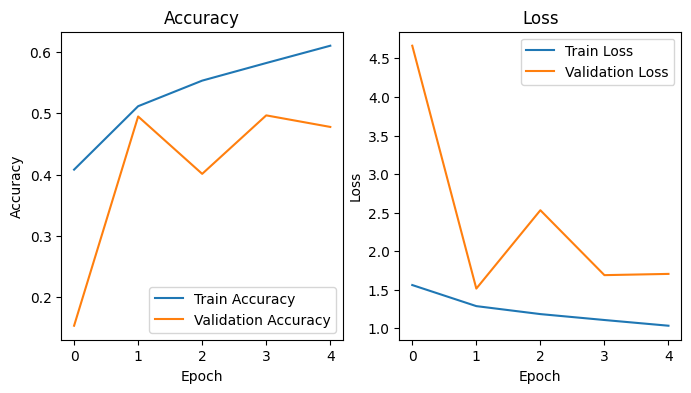

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Etiketlerin (lezyon türü) gerçek isimleri ve etiket numaraları
class_labels = {
    0: 'Actinic Keratosis',    # akiec
    1: 'Basal Cell Carcinoma', # bcc
    2: 'Benign Keratosis',     # bkl
    3: 'Dermatofibroma',       # df
    4: 'Melanoma',            # mel
    5: 'Melanocytic Nevi',    # nv
    6: 'Vascular Lesion'      # vasc
}



print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels.values()))

# Modelin genel olarak doğruluğunu, hassasiyetini, duyarlılığını ve f1 puanını hesaplar ve yazdırır
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Precision (Weighted): {precision:.4f}")
print(f"Recall (Weighted): {recall:.4f}")
print(f"F1-Score (Weighted): {f1:.4f}")

# Modelin eğitimi boyunca elde edilen model parametrelerini tablo halinde her bir epoch sonunda olacak şekilde yazdırır
def plot_metrics(history):
    plt.figure(figsize=(8, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Eğitim sürecindeki elde edilen model parametrelerini grafik olarak gösterir
plot_metrics(history)

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np


# Modeli kullanarak belirtilen görüntü dosyalarını sınıflandırarak ve tahmin edilen sonuçları
# datasetteki gerçek etiketler ile birlikte bir grafik üzerinde görselleştirir ve gerçek etiket değeri ile
# modelin tahmini arasındaki farkı görmemizi sağlar.
def classify_and_plot_images(model, image_paths, true_labels):
    plt.figure(figsize=(30, 15))

    for i, image_path in enumerate(image_paths):
        img = load_img(image_path, target_size=(128,128))
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255.0

        prediction = model.predict(img_array)
        predicted_class = np.argmax(prediction, axis=1)[0]
        confidence = np.max(prediction)

        plt.subplot(2, 4, i + 1)
        plt.imshow(load_img(image_path))
        plt.title(f"True: {class_labels[true_labels[i]]}\nPredicted: {class_labels[predicted_class]}\nAccuracy: {confidence:.2f}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Etiketlemiş olduğumuz veri setinden rastgele 8 örnek seçer
sample_metadata = meta_data.sample(n=8)

# Seçilen görüntülerin dosya adı (.jpg ve .png şeklinde) ve dosya yolu oluşturularak boş bir liste oluşturulur ve buraya kaydedilir
sample_image_paths = []
sample_true_labels = []
for _, row in sample_metadata.iterrows():
    image_id = row['image_id'] + '.jpg'
    image_path = os.path.join(final_image_dataset, image_id)
    # Görüntülerin dosya yollarını kontrol ederek doğru dosya yolunda bulunma kontorlü yapar
    if os.path.exists(image_path):
        sample_image_paths.append(image_path)
        sample_true_labels.append(label_mapping[row['dx']])
    else:
        print(f"Warning: Image {image_path} not found.")

# Oluşturulan listeleri kontrol eder ve yapılan lezyon türü sınıflandırmasına göre seçilen görüntülerle oluşturulan listeleri çağrırır
print("Sample image paths:", sample_image_paths)
print("Sample true labels:", sample_true_labels)

# Seçilen görüntüler için mevcut olan lezyon türü etiketleri
class_labels = {
    0: 'Actinic Keratosis',
    1: 'Basal Cell Carcinoma',
    2: 'Benign Keratosis',
    3: 'Dermatofibroma',
    4: 'Melanoma',
    5: 'Melanocytic Nevi',
    6: 'Vascular Lesion'
}

if sample_image_paths and sample_true_labels:
    classify_and_plot_images(model, sample_image_paths, sample_true_labels)
else:
    print("No valid images found. Please check the image paths.")

Output hidden; open in https://colab.research.google.com to view.